# Data Collection

In [104]:
import pandas as pd

df = pd.read_csv("../data/yahoo_answers.csv")

human_answers = df["answer"].tolist()
for i, answer in enumerate(human_answers):
  with open("../data/responses.csv", "a") as f:
    f.write(f'{i},"{answer}",human\n')


In [120]:
df = pd.read_csv("../data/yahoo_answers.csv")

df["question"] = df["header"] + " " + df["subheader"] if type(df["subheader"]) == "string" else ""
questions = df["question"].tolist()

DELIMETER = "|"
for i, answer in enumerate(df["answer"]):
  if type(answer) == str:
    answer = answer.replace("|", "")
  with open("../data/responses.csv", "a") as f:
    f.write(f'{i}{DELIMETER}"{answer}"{DELIMETER}human\n')

In [ ]:
from time import sleep
import os
import pandas as pd
import openai
from dotenv import load_dotenv

load_dotenv

openai.api_key = os.getenv("OPENAI_API_KEY")

df = pd.read_csv("../data/yahoo_answers.csv")
df["question"] = df["header"] + (" " + df["subheader"] if type(df["subheader"]) == str else "")
questions = df["question"]

DELIMETER = "|"

responses_df = pd.read_csv("../data/responses.csv", sep=DELIMETER)
num_answers = len(responses_df)
responses_df = responses_df[responses_df["category"] == "ChatGPT"]

for i, question in enumerate(questions):
  if i % 100 == 0:
    print(f"Processing question {i} of {len(questions)}")
  if i < len(responses_df):
    continue
  should_break = False
  while not should_break:
    try:
      response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
              {"role": "system", "content": "Respond to the following question like you are a human answering a short essay prompt."},
              {"role": "user", "content": question},
          ]
      )
      should_break = True
    except Exception as e:
      # if the OpenAI API is overloaded, wait 2 minutes and try again
      print(e)
      sleep(120)

  answer = response["choices"][0]["message"]["content"]
  items_to_remove = [
    "As an AI language model, ",
    "Sorry, as an AI language model ",
    "I'm sorry, as an AI language model, ",
    "I'm sorry, but as an AI language model, ",
    "I do not have personal preferences or emotions. ",
    "I do not have personal preferences or emotions, but ",
    "I do not have personal beliefs or opinions. ",
    "As a language model AI, ",
    "|",
    "\n"
  ]
  for item in items_to_remove:
    answer = answer.replace(item, "")
  answer = answer.replace('"', "'")
  answer = answer.replace(":", ": ")

  with open("../data/responses.csv", "a") as f:
    f.write(f'{num_answers+i}{DELIMETER}"{answer}"{DELIMETER}ChatGPT\n')

In [3]:
import math
import random
import pandas as pd

df = pd.read_csv("../data/responses.csv", sep="|")
ai = df[df["category"] == "ChatGPT"]
human = df[df["category"] == "human"]
number_to_use = math.floor((len(ai) / len(human)) * len(human))

human_to_use = random.sample(human["text"].tolist(), number_to_use)
ai_to_use = ai["text"].tolist()

# # create a dataframe with human_to_use with the category "human" and ai_to_use with the category "ChatGPT"
data = []
data += [[item, "human"] for item in human_to_use]
data += [[item, "ChatGPT"] for item in ai_to_use]
df = pd.DataFrame(data, columns=["text", "category"])

df.to_csv("../data/data.csv", sep="|")

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy

nlp = spacy.load("en_core_web_sm")

df = pd.read_csv("../data/data.csv", sep="|")

def tokenize_text(text):
    doc = nlp(str(text))
    return ",".join([token.text for token in doc])

df["tokens"] = df["text"].apply(tokenize_text)


In [ ]:
# get the median number of tokens in each category
human_median = df[df["category"] == "human"]["tokens"].apply(lambda x: len(x)).median()
ai_median = df[df["category"] == "ChatGPT"]["tokens"].apply(lambda x: len(x)).median()

# graph the median length of each category
plt.bar(["human", "ChatGPT"], [human_median, ai_median])

In [1]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
import pandas as pd
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jacobpatton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacobpatton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jacobpatton/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
df = pd.read_csv("../data/data.csv", sep="|")
df["text"] = df["text"].apply(lambda x: str(x))

In [3]:
def get_tokens(texts):
  tokens = [word_tokenize(text, language='english') for text in texts]
  return tokens

In [4]:
df["tokens"] = get_tokens(df["text"].tolist())

In [33]:
import json

# x = [len(item) for item in df["tokens"].tolist()]
# y = [round((len(set(item)) / len(item)) * 100) for item in df["tokens"].tolist()]
# colors = ["red" if item == "human" else "blue" for item in df["category"].tolist()]

data = []
for i, item in enumerate(df["tokens"].tolist()):
  data += [{"x": len(item), "y": round((len(set(item)) / len(item)) * 100), "backgroundColor": colors[i]}]

with open("../frontend/src/data/word_counts.json", "w") as f:
  json.dump(data, f)

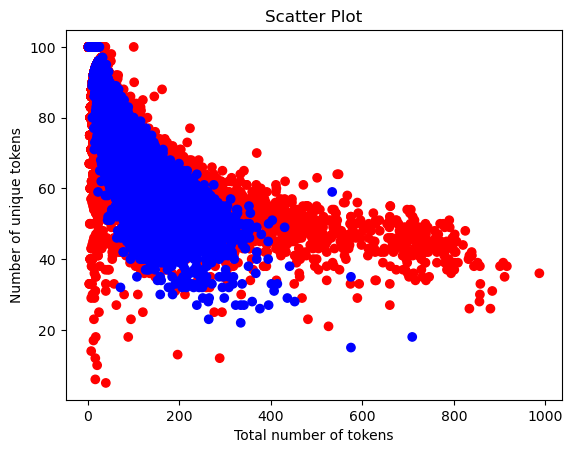

In [6]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.scatter(x, y, c=colors)

# Add labels and title
plt.xlabel('Total number of tokens')
plt.ylabel('Number of unique tokens')
plt.title('Scatter Plot')

# Display the plot
plt.show()


In [9]:
print(df["tokens"][0])

['well', 'i', 'could', 'make', 'several', 'comments', 'to', 'this', 'question', 'but', 'i', 'am', 'tempted', 'to', 'say', 'do', "n't", 'even', 'try', 'to', 'as', 'they', 'will', 'possible', 'be', 'black', 'market', 'especially', 'in', 'England.\\nHave', 'you', 'tryed', 'bayern', 'leverkusen', 'web', 'site', ',', 'try', 'a', 'google', 'search', 'for', 'that', 'one', '.', 'But', 'my', 'best', 'answer', 'is', 'save', 'the', 'money', 'and', 'stay', 'at', 'home', '.', 'it', 'will', 'be', 'warmer', 'and', 'you', 'will', 'be', 'able', 'to', 'sit', 'on', 'your', 'favourite', 'chair', 'and', 'shout', 'at', 'the', 'TV', 'without', 'any', 'type', 'of', 'after', 'match', 'problems', 'like', 'fights', 'and', 'being', 'arrested', '.', 'Also', 'you', 'will', 'save', 'money', 'on', 'travel', 'just', 'think', 'how', 'many', 'beers', 'you', 'could', 'buy', 'with', 'what', 'you', 'will', 'save']


In [7]:
custom_stop_words = ["'s", "n't"]

# parts of speech to exclude
# genitive marker (POS), particle (RP), list item marker (LS), coordinating conjunction (CC)
pos_to_exclude = ['POS', 'RP', 'LS', 'CC']

def get_word_counts(texts, get_trigrams=False):
  tokens = [word_tokenize(text, language='english') for text in texts]

  words = []
  for sublist in tokens:
    pos = nltk.pos_tag(sublist)
    for i, item in enumerate(sublist):
      if item.lower() not in stopwords.words('english') and item.lower() not in custom_stop_words and pos[i][1] not in pos_to_exclude and re.search(r'\w', item):
        words.append(item)

  word_counts = {}
  for word in words:
    if word.lower() in word_counts:
      word_counts[word.lower()] += 1
    else:
      word_counts[word.lower()] = 1

  trigram_counts = {}
  if get_trigrams:
    for text in tokens:
      trigrams = ngrams(text, 3)
      trigrams = [' '.join(grams) for grams in trigrams]
      for trigram in trigrams:
        trigram = trigram.lower()
        should_use = True
        for word in trigram.split(" "):
          if not re.search(r'\w', word):
            should_use = False
        if not should_use:
          continue
        if trigram in trigram_counts:
          trigram_counts[trigram] += 1
        else:
          trigram_counts[trigram] = 1

  return word_counts, trigram_counts

human_word_counts, human_trigram_counts = get_word_counts(df[df["category"] == "human"]["text"].values)
ai_word_counts, ai_trigram_counts = get_word_counts(df[df["category"] == "ChatGPT"]["text"].values)

In [8]:
def get_top_n_words(word_counts, n):
  top_n_words = []
  for word, count in word_counts.items():
    if len(top_n_words) < n:
      top_n_words.append((word, count))
    else:
      min = None
      for item in top_n_words:
        if min is None or item[1] < min[1]:
          min = item
      if count > min[1]:
        top_n_words.remove(min)
        top_n_words.append((word, count))
  return sorted(top_n_words, key=lambda x: x[1], reverse=True)

top_20_ai_words = get_top_n_words(ai_word_counts, 20)
top_20_human_words = get_top_n_words(human_word_counts, 20)

# top_50_ai_trigrams = get_top_n_words(ai_trigram_counts, 50)
# top_50_human_trigrams = get_top_n_words(human_trigram_counts, 50)

In [31]:
x = [len(item) for item in df["tokens"].tolist()]
y = []
for item in df.iterrows():
  category = item[1]["category"]
  item = item[1]["tokens"]
  top_20_list = top_20_human_words if category == "human" else top_20_ai_words
  top_20_list = [item[0] for item in top_20_list]
  tokens_in_top_20 = [token for token in item if token in top_20_list]
  y.append(round(len(tokens_in_top_20) / len(item) * 100))
colors = ["red" if item == "human" else "blue" for item in df["category"].tolist()]

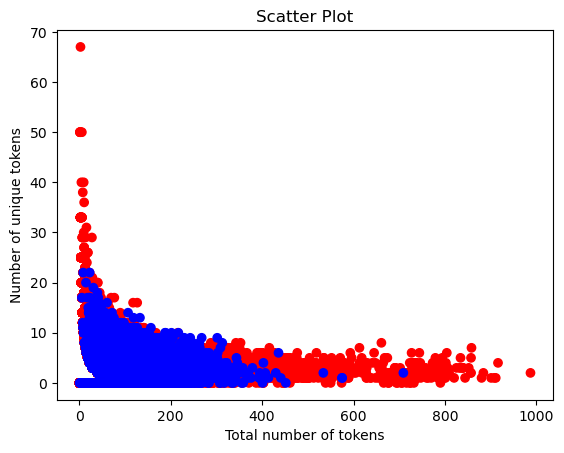

In [32]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.scatter(x, y, c=colors)

# Add labels and title
plt.xlabel('Total number of tokens')
plt.ylabel('Number of unique tokens')
plt.title('Scatter Plot')

# Display the plot
plt.show()

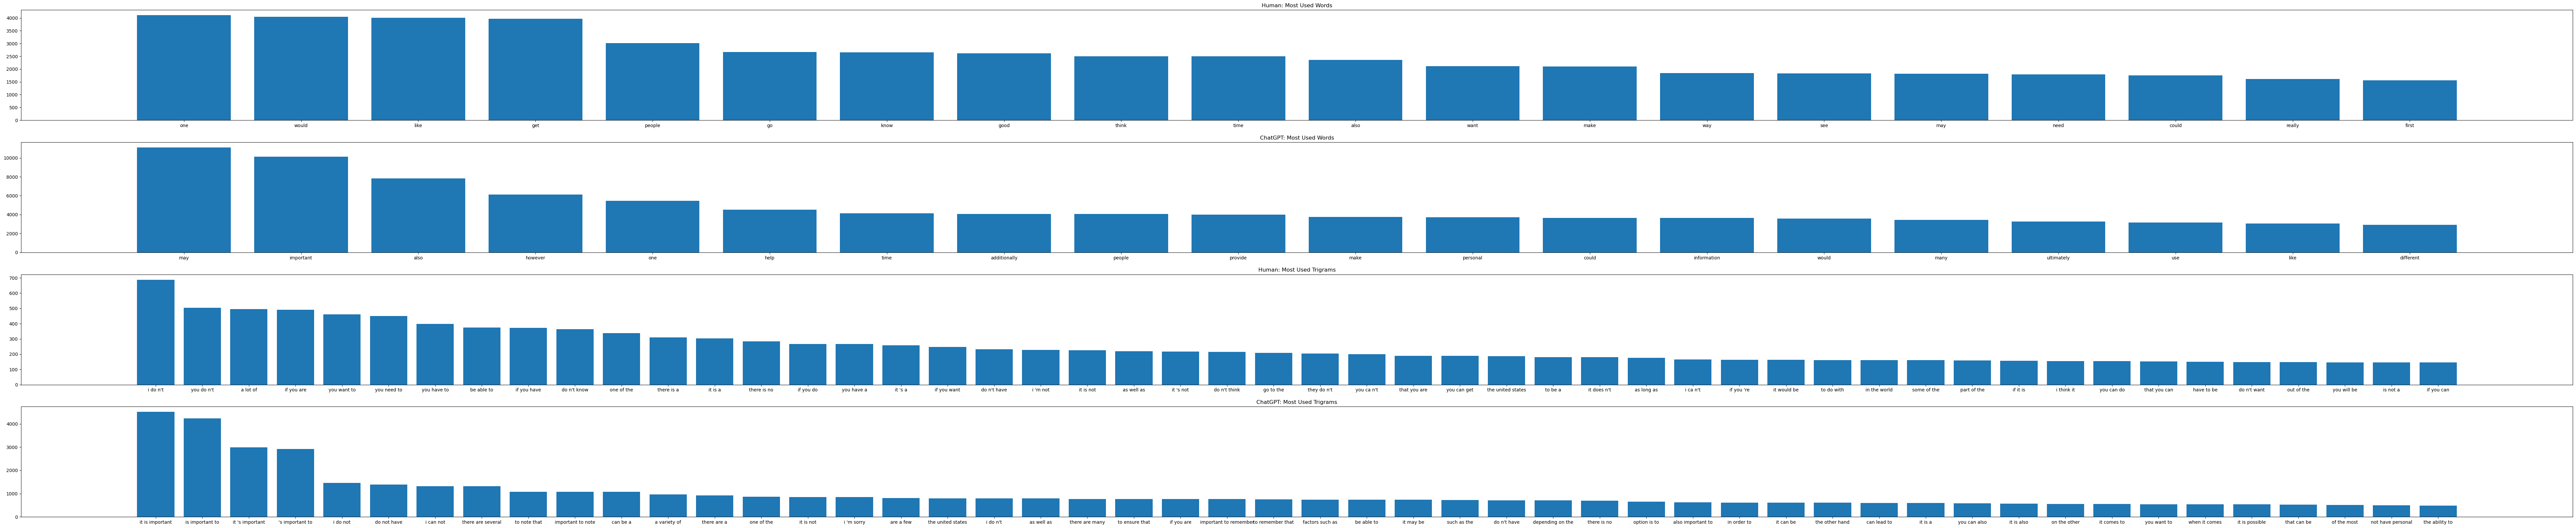

In [3]:
import matplotlib.pyplot as plt

human_x = [item[0] for item in top_20_human_words]
human_y = [item[1] for item in top_20_human_words]

ai_x = [item[0] for item in top_20_ai_words]
ai_y = [item[1] for item in top_20_ai_words]

human_trigram_x = [item[0] for item in top_50_human_trigrams]
human_trigram_y = [item[1] for item in top_50_human_trigrams]

ai_trigram_x = [item[0] for item in top_50_ai_trigrams]
ai_trigram_y = [item[1] for item in top_50_ai_trigrams]

fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(100)

plt.subplot(4, 1, 1)
plt.bar(human_x, human_y)
plt.title("Human: Most Used Words")

plt.subplot(4, 1, 2)
plt.bar(ai_x, ai_y)
plt.title("ChatGPT: Most Used Words")

plt.subplot(4, 1, 3)
plt.bar(human_trigram_x, human_trigram_y)
plt.title("Human: Most Used Trigrams")

plt.subplot(4, 1, 4)
plt.bar(ai_trigram_x, ai_trigram_y)
plt.title("ChatGPT: Most Used Trigrams")

plt.show()

In [5]:
import json

with open("../frontend/src/data/trigrams.json", "w") as f:
  json.dump({
    "human": human_trigram_counts,
    "ai": ai_trigram_counts
  }, f)

In [101]:
def get_percentages(texts):
  percentages = {}
  for text in texts:
    for word in top_20_ai_words:
      if word[0] in text.lower():
        if word[0] in percentages:
          percentages[word[0]] += 1
        else:
          percentages[word[0]] = 1

  percentages = [(word, count) for word, count in percentages.items()]
  percentages = sorted(percentages, key=lambda x: x[1], reverse=True)
  percentages = [(word, round((count / len(texts)) * 100)) for word, count in percentages]

  return percentages

ai_percentages = get_percentages(df[df["category"] == "ChatGPT"]["text"].values)
human_percentages = get_percentages(df[df["category"] == "human"]["text"].values)

In [112]:
ai_percentages_dict = {
  "word": [item[0] for item in ai_percentages],
  "percentages": [item[1] for item in ai_percentages],
}

human_percentages_df = {
  "word": [item[0] for item in human_percentages],
  "percentages": [item[1] for item in human_percentages],
}

with open("../data/ai_percentages.json", "w") as f:
  json.dump(ai_percentages_dict, f)

with open("../data/human_percentages.json", "w") as f:
  json.dump(human_percentages_df, f)

In [110]:
import json

ai_words_dict = {
  "word": [item[0] for item in top_20_ai_words],
  "count": [item[1] for item in top_20_ai_words],
}

with open("../data/ai_words.json", "w") as f:
  json.dump(ai_words_dict, f)

human_words_dict = {
  "word": [item[0] for item in top_20_human_words],
  "count": [item[1] for item in top_20_human_words],
}

with open("../data/human_words.json", "w") as f:
  json.dump(human_words_dict, f)

In [111]:
ai_trigrams_dict = {
  "trigram": [item[0] for item in top_50_ai_trigrams],
  "count": [item[1] for item in top_50_ai_trigrams],
}

human_trigrams_dict = {
  "trigram": [item[0] for item in top_50_human_trigrams],
  "count": [item[1] for item in top_50_human_trigrams],
}

with open("../data/ai_trigrams.json", "w") as f:
  json.dump(ai_trigrams_dict, f)

with open("../data/human_trigrams.json", "w") as f:
  json.dump(human_trigrams_dict, f)

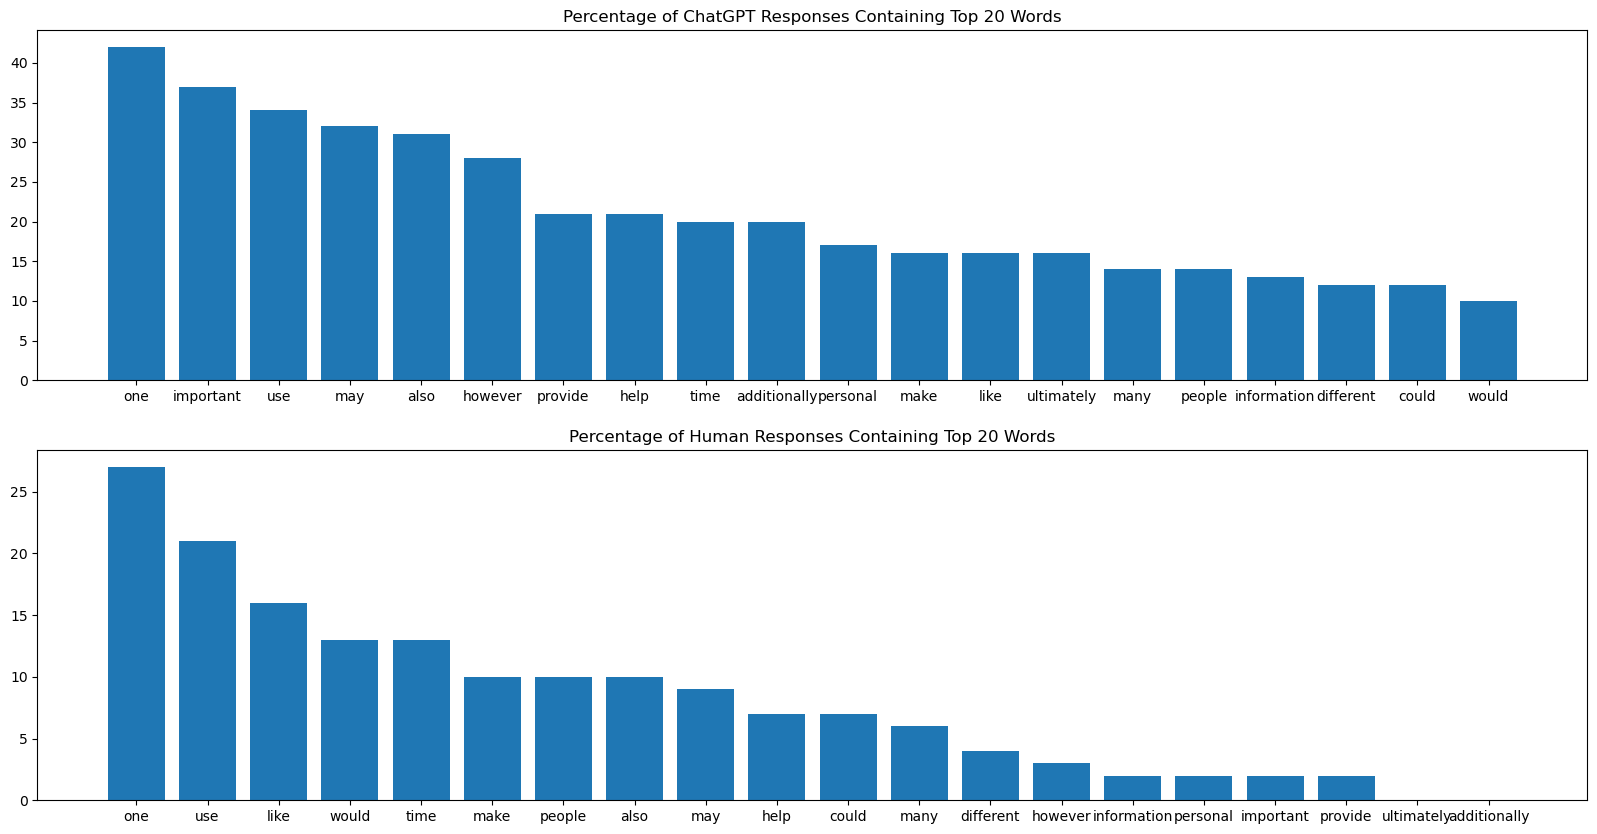

In [102]:
human_percentages_x = [item[0] for item in human_percentages]
human_percentages_y = [item[1] for item in human_percentages]

ai_percentages_x = [item[0] for item in ai_percentages]
ai_percentages_y = [item[1] for item in ai_percentages]

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)

plt.subplot(2, 1, 1)
plt.bar(ai_percentages_x, ai_percentages_y)
plt.title("Percentage of ChatGPT Responses Containing Top 20 Words")

plt.subplot(2, 1, 2)
plt.bar(human_percentages_x, human_percentages_y)
plt.title("Percentage of Human Responses Containing Top 20 Words")

plt.show()

